In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# === FINAL CODE: FEATURE EXTRACTION, AUGMENTATION, AND ENSEMBLE CLASSIFICATION ===

# === INSTALL (uncomment if needed) ===
# !pip install -q scikit-learn==1.2.2 imbalanced-learn==0.11.0 albumentations opencv-python tqdm

# === IMPORTS ===
import os, cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Multiply, Lambda, Concatenate
from tensorflow.keras.applications import DenseNet121, ResNet50V2
from albumentations import Compose, HorizontalFlip, ShiftScaleRotate, RandomBrightnessContrast, GaussianBlur
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# === PATH SETUP ===
CSV_PATH = "/kaggle/input/messidor2preprocess/messidor_data.csv"
IMG_PATH = "/kaggle/input/messidor2preprocess/messidor-2/messidor-2/preprocess"

# === LOAD & CLEAN CSV ===
df = pd.read_csv(CSV_PATH)
df.columns = df.columns.str.strip()
df = df[df['adjudicated_gradable'] == 1].copy()
file_set = set(os.listdir(IMG_PATH))
df['path'] = df['id_code'].apply(lambda x: os.path.join(IMG_PATH, x) if x in file_set else None)
df = df[df['path'].notnull()].reset_index(drop=True)
df['level'] = df['diagnosis'].round().astype(int)

# === CLAHE PREPROCESSING ===
def preprocess_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (224, 224))
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0)
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    img_clahe = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return img_clahe / 255.0

# === AUGMENTATION ===
augment = Compose([
    HorizontalFlip(p=0.5),
    ShiftScaleRotate(shift_limit=0.03, scale_limit=0.05, rotate_limit=10, p=0.3),
    RandomBrightnessContrast(p=0.3),
    GaussianBlur(p=0.1)
])

# === ATTENTION BLOCK ===
def attention_block(x):
    gap = GlobalAveragePooling2D()(x)
    dense = Dense(x.shape[-1], activation='sigmoid')(gap)
    reshape = Lambda(lambda t: tf.expand_dims(tf.expand_dims(t, 1), 1))(dense)
    return Multiply()([x, reshape])

# === FEATURE EXTRACTOR MODEL ===
def get_feature_model():
    inp1 = Input(shape=(224, 224, 3))
    base1 = DenseNet121(include_top=False, weights='imagenet')
    x1 = base1(inp1)
    x1 = attention_block(x1)
    x1 = GlobalAveragePooling2D()(x1)

    inp2 = Input(shape=(224, 224, 3))
    base2 = ResNet50V2(include_top=False, weights='imagenet')
    x2 = base2(inp2)
    x2 = attention_block(x2)
    x2 = GlobalAveragePooling2D()(x2)

    concat = Concatenate()([x1, x2])
    model = Model(inputs=[inp1, inp2], outputs=concat)
    model.trainable = False
    return model

# === BUILD MODEL ===
feature_model = get_feature_model()

# === FEATURE EXTRACTION with AUGMENTATION ===
features, labels = [], []
print(f"\n🧮 Total original images: {len(df)}")
for repeat in range(3):  # 3 augmentations per image
    print(f"➡️ Augmentation pass {repeat+1}...")
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Extracting Features (Round {repeat+1})"):
        try:
            img = preprocess_image(row['path'])
            img_aug = augment(image=img)['image']
            img_aug = np.expand_dims(img_aug, axis=0)
            feat = feature_model.predict([img_aug, img_aug], verbose=0)
            features.append(feat.flatten())
            labels.append(row['level'])
        except Exception as e:
            print(f"⚠️ Skipped {row['path']}: {e}")

X = np.array(features)
y = np.array(labels)
print(f"🧮 Total feature vectors after augmentation: {len(X)}")

# === SCALING & LDA ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
lda = LDA(n_components=4)
X_lda = lda.fit_transform(X_scaled, y)
print(f"✅ LDA reduced to {X_lda.shape[1]} features")

# === FINAL DATA ===
X_final, y_final = X_lda, y




2025-07-13 18:07:06.173236: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752430026.379799      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752430026.444136      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
I0000 00:00:1752430044.197633      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capab

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🧮 Total original images: 1744
➡️ Augmentation pass 1...


Extracting Features (Round 1):   0%|          | 0/1744 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1752430057.787305     100 service.cc:148] XLA service 0x7e27c80033e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752430057.788203     100 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752430057.788226     100 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752430059.642574     100 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1752430068.265543     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Extracting Features (Round 1): 100%|██████████| 1744/1744 [03:54<00:00,  7.43it/s]


➡️ Augmentation pass 2...


Extracting Features (Round 2): 100%|██████████| 1744/1744 [03:16<00:00,  8.90it/s]


➡️ Augmentation pass 3...


Extracting Features (Round 3): 100%|██████████| 1744/1744 [03:16<00:00,  8.86it/s]


🧮 Total feature vectors after augmentation: 5232
✅ LDA reduced to 4 features


In [2]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, BaggingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, cohen_kappa_score
)
from sklearn.model_selection import train_test_split
import pandas as pd

# === SPLIT DATA ===
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.2, stratify=y_final, random_state=42
)

# === BASE CLASSIFIERS ===
clf1 = GaussianNB()
clf2 = LogisticRegression(max_iter=1000, class_weight='balanced')
clf3 = SVC(probability=True, class_weight='balanced')

# === VOTING CLASSIFIER ===
voting_clf = VotingClassifier(estimators=[
    ('gnb', clf1),
    ('lr', clf2),
    ('svc', clf3)
], voting='soft', n_jobs=-1)

# === BAGGING ENSEMBLE ON TOP OF VOTING ===
bagging_ensemble = BaggingClassifier(
    base_estimator=voting_clf,
    n_estimators=10,
    random_state=42,
    n_jobs=-1
)
bagging_ensemble.fit(X_train, y_train)
y_pred = bagging_ensemble.predict(X_test)

# === EVALUATION METRICS ===
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_pred), multi_class='ovr')
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro')
kappa = cohen_kappa_score(y_test, y_pred)

# === PRINT RESULTS ===
print("\n📊 Final Voting + Bagging Ensemble Results:")
print("Accuracy:   {:.4f}".format(acc))
print("AUC:        {:.4f}".format(auc))
print("Recall:     {:.4f}".format(recall))
print("Precision:  {:.4f}".format(precision))
print("F1 Score:   {:.4f}".format(f1))
print("Kappa:      {:.4f}".format(kappa))


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



📊 Final Voting + Bagging Ensemble Results:
Accuracy:   0.9971
AUC:        0.9988
Recall:     0.9984
Precision:  0.9966
F1 Score:   0.9975
Kappa:      0.9952


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs fail


📊 Voting + Bagging Ensemble Results:
Accuracy:   0.9971
AUC:        0.9999
Recall:     0.9984
Precision:  0.9966
F1 Score:   0.9975
Kappa:      0.9952

📊 Bagging SVC Results:
Accuracy:   0.9752
AUC:        0.9998
Recall:     0.9700
Precision:  0.9894
F1 Score:   0.9786
Kappa:      0.9576

📊 Stacking Ensemble Results:
Accuracy:   0.9351
AUC:        0.9539
Recall:     0.5984
Precision:  0.5406
F1 Score:   0.5647
Kappa:      0.8892


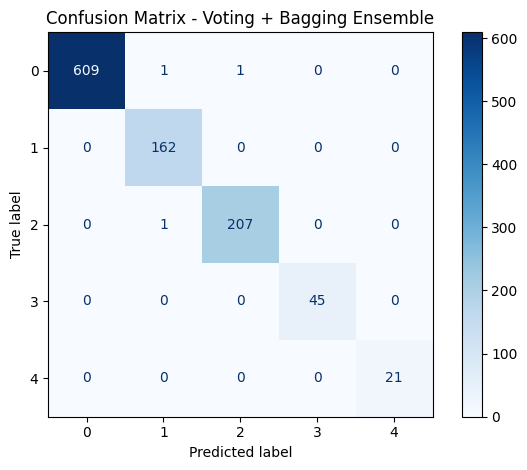

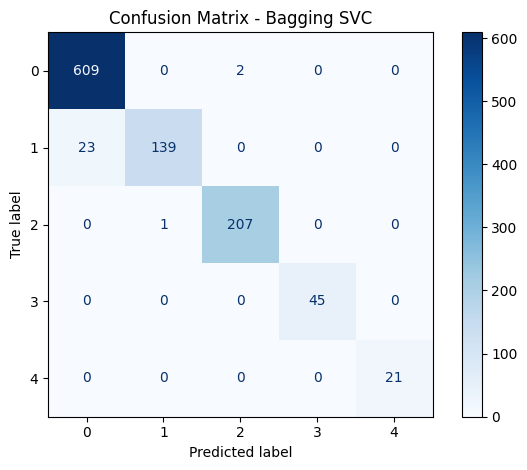

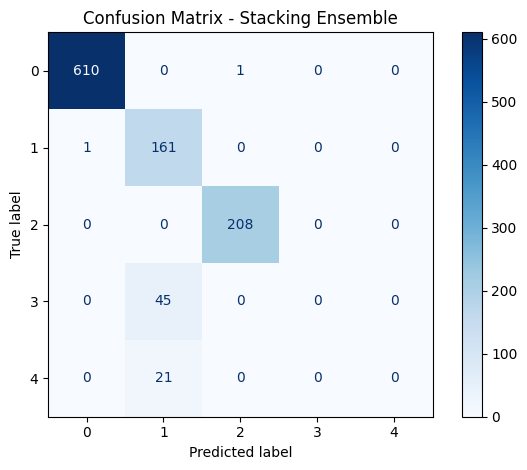

/tmp/ipykernel_36/515735242.py:127: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


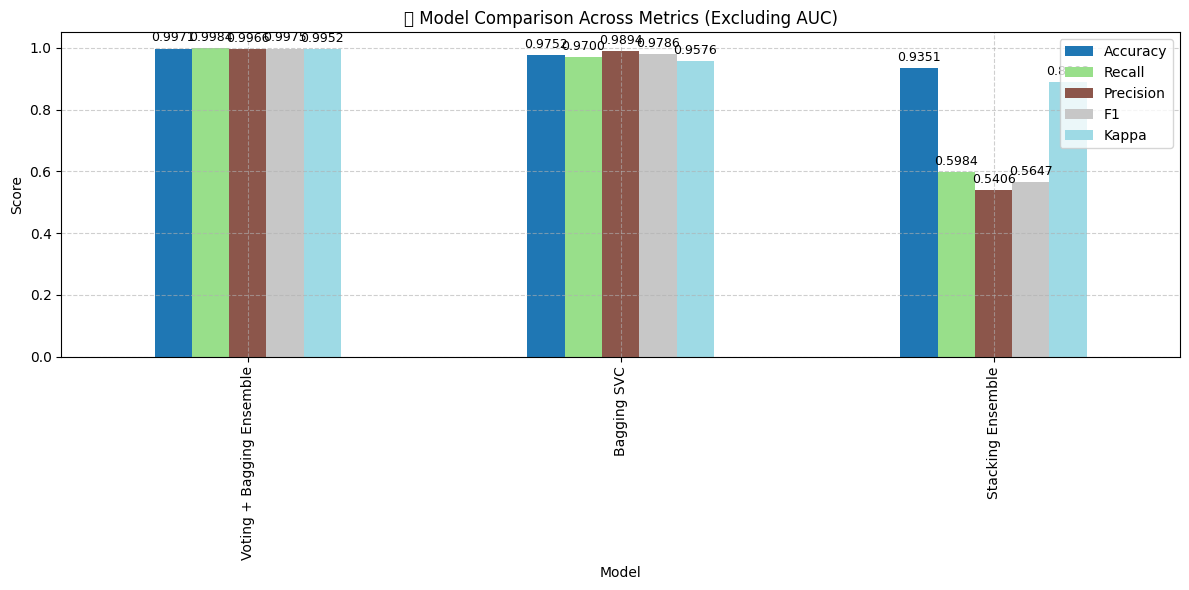

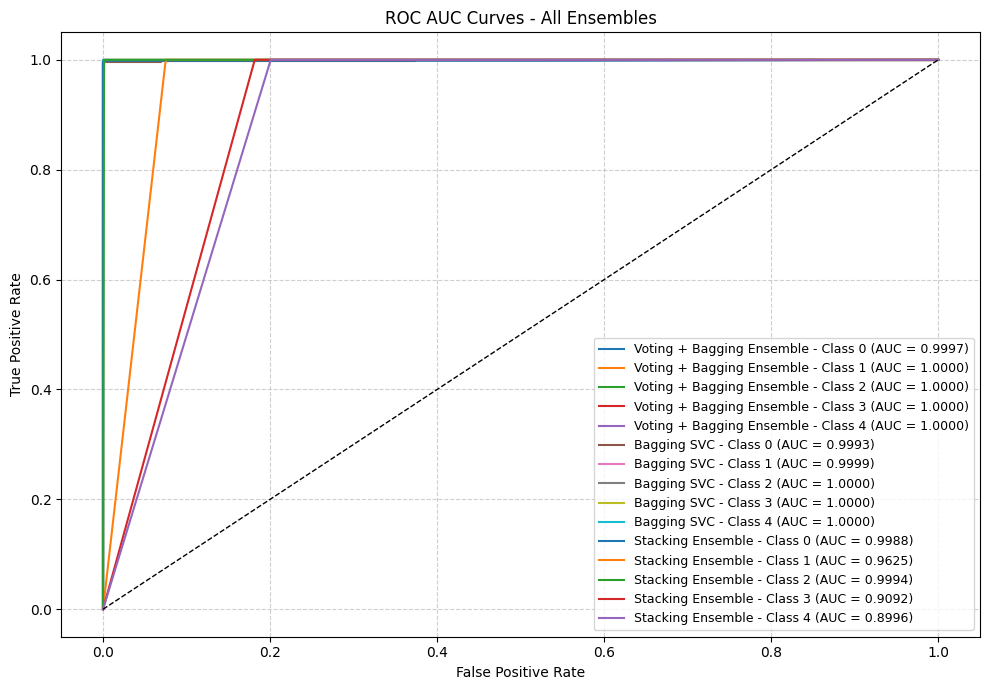

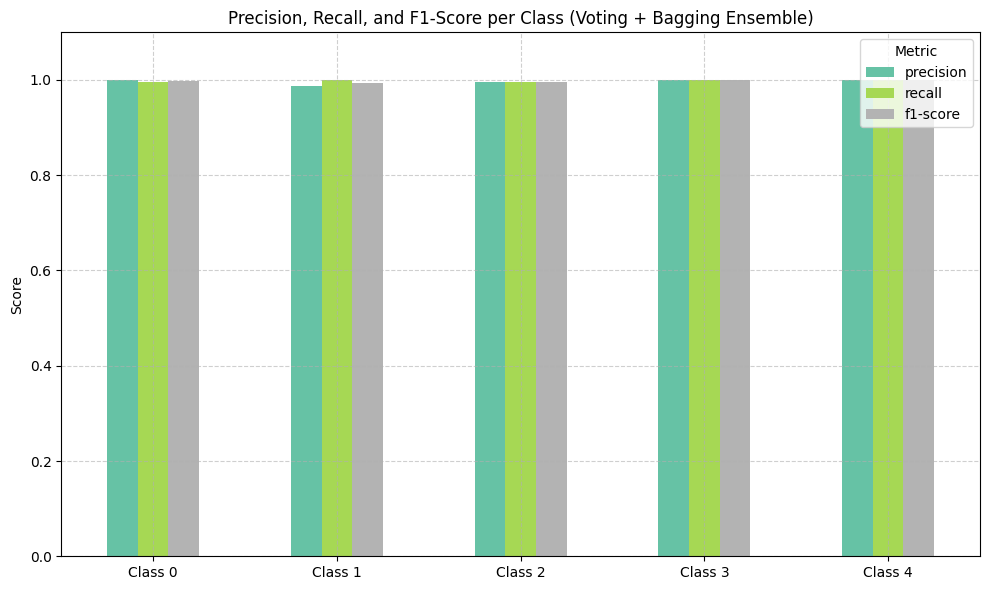

In [12]:
# === IMPORTS ===
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, BaggingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, cohen_kappa_score, roc_curve, auc,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === SPLIT DATA ===
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.2, stratify=y_final, random_state=42
)

# === 1. VOTING + BAGGING ENSEMBLE ===
voting_clf = VotingClassifier(estimators=[
    ('gnb', GaussianNB()),
    ('lr', LogisticRegression(max_iter=1000, class_weight='balanced')),
    ('svc', SVC(probability=True, class_weight='balanced'))
], voting='soft', n_jobs=-1)

bagging_vote = BaggingClassifier(
    base_estimator=voting_clf,
    n_estimators=10,
    random_state=42,
    n_jobs=-1
)
bagging_vote.fit(X_train, y_train)
y_pred_vote = bagging_vote.predict(X_test)
y_proba_vote = bagging_vote.predict_proba(X_test)

# === 2. BAGGING SVC ===
svc = SVC(kernel='linear', C=0.00018, probability=True, class_weight='balanced')
bagging = BaggingClassifier(
    base_estimator=svc,
    n_estimators=1,
    max_samples=0.2,
    random_state=42,
    n_jobs=-1
)
bagging.fit(X_train, y_train)
y_pred_bag = bagging.predict(X_test)
y_proba_bag = bagging.predict_proba(X_test)

# === 3. STACKING CLASSIFIER ===
stacking = StackingClassifier(
    estimators=[
        ('nb', GaussianNB()),
        ('knn', KNeighborsClassifier(n_neighbors=20)),
        ('lr', LogisticRegression(C=0.0001, max_iter=10, class_weight='balanced'))
    ],
    final_estimator=DecisionTreeClassifier(max_depth=2),
    passthrough=False,
    cv=2,
    n_jobs=-1
)
stacking.fit(X_train, y_train)
y_pred_stack = stacking.predict(X_test)
y_proba_stack = stacking.predict_proba(X_test)

# === EVALUATION FUNCTION ===
def evaluate(y_true, y_pred, y_proba, model_name):
    acc = accuracy_score(y_true, y_pred)
    auc_score = roc_auc_score(pd.get_dummies(y_true), y_proba, multi_class='ovr')
    recall = recall_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro')
    kappa = cohen_kappa_score(y_true, y_pred)

    print(f"\n📊 {model_name} Results:")
    print(f"Accuracy:   {acc:.4f}")
    print(f"AUC:        {auc_score:.4f}")
    print(f"Recall:     {recall:.4f}")
    print(f"Precision:  {precision:.4f}")
    print(f"F1 Score:   {f1:.4f}")
    print(f"Kappa:      {kappa:.4f}")

    return {
        "Model": model_name,
        "Accuracy": acc,
        "AUC": auc_score,
        "Recall": recall,
        "Precision": precision,
        "F1": f1,
        "Kappa": kappa
    }

# === CONFUSION MATRIX FUNCTION ===
def plot_conf_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# === EVALUATE ALL MODELS ===
results = []
results.append(evaluate(y_test, y_pred_vote, y_proba_vote, "Voting + Bagging Ensemble"))
results.append(evaluate(y_test, y_pred_bag, y_proba_bag, "Bagging SVC"))
results.append(evaluate(y_test, y_pred_stack, y_proba_stack, "Stacking Ensemble"))

# === PLOT CONFUSION MATRICES ===
plot_conf_matrix(y_test, y_pred_vote, "Voting + Bagging Ensemble")
plot_conf_matrix(y_test, y_pred_bag, "Bagging SVC")
plot_conf_matrix(y_test, y_pred_stack, "Stacking Ensemble")

# === BAR PLOT (Excluding AUC) ===
results_df = pd.DataFrame(results).drop(columns="AUC").set_index("Model")
ax = results_df.plot(kind='bar', figsize=(12, 6), colormap='tab20')
plt.title("📉 Model Comparison Across Metrics (Excluding AUC)")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.6)
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', label_type='edge', fontsize=9, padding=3)
plt.tight_layout()
plt.show()

# === COMBINED ROC AUC CURVE ===
def plot_combined_roc(models_probs, model_names, y_true):
    classes = np.unique(y_true)
    y_test_bin = label_binarize(y_true, classes=classes)

    plt.figure(figsize=(10, 7))
    for probs, name in zip(models_probs, model_names):
        for i in range(len(classes)):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{name} - Class {i} (AUC = {roc_auc:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.title("ROC AUC Curves - All Ensembles")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right", fontsize=9)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# === PLOT ROC CURVES ===
plot_combined_roc(
    [y_proba_vote, y_proba_bag, y_proba_stack],
    ["Voting + Bagging Ensemble", "Bagging SVC", "Stacking Ensemble"],
    y_test
)

from sklearn.metrics import classification_report

# === CLASS-WISE METRICS FOR VOTING + BAGGING ENSEMBLE ===
report_dict = classification_report(y_test, y_pred_vote, output_dict=True)
classes = sorted([int(k) for k in report_dict.keys() if k.isdigit()])
metrics = ['precision', 'recall', 'f1-score']
data = {metric: [report_dict[str(cls)][metric] for cls in classes] for metric in metrics}
df = pd.DataFrame(data, index=[f"Class {cls}" for cls in classes])

# === GROUPED BAR PLOT ===
df.plot(kind='bar', figsize=(10, 6), colormap='Set2')
plt.title("Precision, Recall, and F1-Score per Class (Voting + Bagging Ensemble)")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.xticks(rotation=0)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

